In [3]:
import pandas as pd 
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy import stats

%matplotlib inline
sns.set_style("white")

base_dir = os.path.dirname(os.getcwd())

## Load data

In [8]:
data_turn_taking = pd.read_csv(os.path.join(base_dir,'Analyses','turn_taking_strangers.csv'))
data_connection = pd.read_csv(os.path.join(base_dir,'Analyses','connection_strangers.csv'))
data_outcomes = pd.read_csv(os.path.join(base_dir,'Analyses','post_convo_survey_with_factors_strangers.csv'))

data_interim = pd.merge(data_turn_taking, data_outcomes, how='inner', on=['subID', 'partnerID'])
data = pd.merge(data_interim, data_connection, how='inner', on=['subID', 'partnerID'])

## Mean-center variables of interest

In [9]:
features = ['factor_1', 'avg_connection', 'mean_gap_convo', 'median_gap_convo', 'mean_gap_speaker',
       'median_gap_speaker', 'mean_gap_partner', 'median_gap_partner']
for feature in features:
    store_mean = data.groupby('subID')[feature].mean()
    new_feature = feature + '_centered'
    for i in range(len(data)):  
        sub = int(data.at[i,'subID'])
        data.at[i, new_feature] = data.at[i, feature] - store_mean[sub] # this changed in python 3.8.
                                                                        # need to call row number, not
                                                                        # subID number
                                                                        # for newer versions, use store_mean.loc['103']

## Compute averages for self ratings and for partner ratings

Centered version tells us whether participants enjoyed / were faster in that convo compared to their other convos vs the absolute ratings (the non-centered version).

Centered versions for SELF don't make sense because those will always be 0. Can be used for partner.

In [14]:
variables = ['factor_1', 'avg_connection', 'mean_gap_convo', 'median_gap_convo', 'mean_gap_speaker',
       'median_gap_speaker', 'mean_gap_partner', 'median_gap_partner',
        'factor_1_centered', 'avg_connection_centered', 'mean_gap_convo_centered', 'median_gap_convo_centered', 'mean_gap_speaker_centered',
       'median_gap_speaker_centered', 'mean_gap_partner_centered', 'median_gap_partner_centered']

output = []

for variable in variables:
        
    output.append(pd.Series(data.groupby('subID')[variable].mean(), name='{}_self_mean'.format(variable)))
    output.append(pd.Series(data.groupby('partnerID')[variable].mean(), name='{}_partner_mean'.format(variable)))

    output.append(pd.Series(data.groupby('subID')[variable].var(), name='{}_self_var'.format(variable)))
    output.append(pd.Series(data.groupby('partnerID')[variable].var(), name='{}_partner_var'.format(variable)))
    
df = pd.concat(output, axis=1).reset_index()
df.rename(columns = {'index':'subID'}, inplace = True)
df 

,subID,factor_1_self_mean,factor_1_partner_mean,factor_1_self_var,factor_1_partner_var,avg_connection_self_mean,avg_connection_partner_mean,avg_connection_self_var,avg_connection_partner_var,mean_gap_convo_self_mean,...,median_gap_speaker_centered_self_var,median_gap_speaker_centered_partner_var,mean_gap_partner_centered_self_mean,mean_gap_partner_centered_partner_mean,mean_gap_partner_centered_self_var,mean_gap_partner_centered_partner_var,median_gap_partner_centered_self_mean,median_gap_partner_centered_partner_mean,median_gap_partner_centered_self_var,median_gap_partner_centered_partner_var
0,1,-0.080691,0.549683,0.288753,1.158708,59.776150,71.876983,89.480317,336.816525,187.004861,...,3609.802778,4576.865667,-1.989520e-14,-20.509599,9983.391544,7201.589143,0.000000e+00,-15.100000,5250.513889,2575.360000
1,2,-0.139533,0.351122,0.886040,0.964066,48.793950,62.869100,413.016186,443.139904,124.161320,...,11005.780556,9841.337667,8.526513e-15,-96.644166,29918.818358,25091.836201,1.136868e-14,-45.605000,20078.177778,9968.728028
2,3,-0.052691,-0.185813,0.138064,1.152126,57.904367,54.230600,36.332301,365.137444,203.146089,...,8376.766667,3295.725583,-2.842171e-14,36.000077,32095.668638,10583.600037,-1.136868e-14,4.580000,9988.469444,3024.081778
3,4,0.466423,-0.091312,0.477395,0.816441,77.501400,60.937267,187.731137,201.110552,103.036790,...,3893.747222,7615.808444,-2.842171e-15,-38.414653,3077.940736,3553.444497,-4.263256e-15,-17.955000,2681.066667,1546.665806
4,5,0.485095,0.157780,0.274856,1.009319,76.212750,65.967350,181.743124,185.716504,265.622965,...,17763.780556,3500.926000,1.989520e-14,117.232699,11234.298396,10764.118989,0.000000e+00,112.250000,5756.791667,10624.246111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,106,-0.066133,-0.502269,0.893764,0.654970,57.117400,52.719100,208.482241,178.953772,461.179855,...,13607.691667,1717.093609,-1.705303e-14,247.551515,15873.812993,12880.844282,-2.273737e-14,175.533333,5722.488889,5669.415892
62,107,0.209255,0.545601,0.945581,0.249225,67.722883,63.559983,97.449827,387.552323,107.492159,...,2863.280556,5800.308189,-7.105427e-15,-193.222617,14392.053226,4369.611470,5.684342e-15,-133.341667,7917.225000,1240.726771
63,108,-0.068618,-0.607406,0.376394,0.446971,70.094500,47.084150,170.150022,277.620191,219.295487,...,14468.447222,3898.153794,-2.842171e-15,-117.394338,30120.542159,5389.837261,-5.684342e-15,-66.261667,9056.058333,5230.755092
64,109,-0.055173,-0.051508,1.215844,1.393233,63.011450,51.870967,631.790131,665.279095,232.330150,...,15523.180556,11583.414745,-2.557954e-14,-96.577716,38031.405081,7109.450210,-1.136868e-14,-61.721667,21100.302778,5757.767685


In [15]:
df.to_csv(os.path.join(base_dir, 'Analyses',
                              'individual_differences.csv'),
                        encoding='utf-8', index=False)

## Are the individual differences "stable"?

Is the gap length variance within an individual smaller than across individuals (or a comparable set of random other people)?

Keep the comparisons within the same round.

In [88]:
metric = 'mean_gap_speaker'

real_vars = []
psuedo_vars = []

subjects = data['subID'].unique()

for subject in subjects:
    
    data_subject = data.loc[data['subID'] == subject].reset_index(drop=True)
    real_vars.append(np.var(data_subject[metric]))
    
for subject in subjects:
    
    round_robin_subset = data.loc[data['subID'].isin(data_subject['partnerID'])].reset_index(drop=True)
    round_robin_subset = round_robin_subset.loc[round_robin_subset['partnerID'] != subject].reset_index(drop=True)
    
    for _ in range(2):
        verify_all_unique = 0
        while verify_all_unique != 10:
            round_robin_subset_random = round_robin_subset.sample(n=10).reset_index(drop=True)
            verify_all_unique = len(round_robin_subset_random['subID'].unique())

        psuedo_vars.append(np.var(round_robin_subset_random[metric]))


/Users/emma/anaconda3/envs/python3_8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/emma/anaconda3/envs/python3_8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


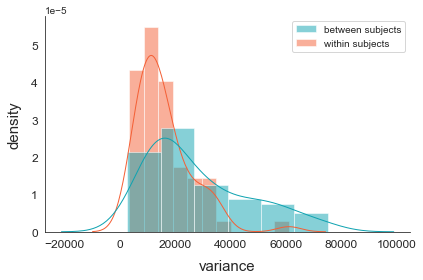

In [83]:
ax = sns.distplot(real_vars, hist = True, kde = True,
             kde_kws = {'linewidth': 1}, color='#F46036', label = 'within subjects', hist_kws=dict(alpha=0.5))
ax = sns.distplot(psuedo_vars, hist = True, kde = True,
             kde_kws = {'linewidth': 1}, color='#0FA3B1', label = 'between subjects', hist_kws=dict(alpha=0.5))

ax.set_xlabel('variance', fontsize=15, labelpad=10)
ax.set_ylabel('density', fontsize=15, labelpad=10)
ax.tick_params(labelsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

sns.despine()
plt.tight_layout()

In [80]:
stats.ttest_ind(real_vars, psuedo_vars, equal_var=False)

Ttest_indResult(statistic=-6.375733406148856, pvalue=2.6344785332875806e-09)